## Living England Habitat Map (Phase 4) Cut to National Parks England

### Summary

Living England Habitat Map (Phase 4) - This map is an output from Phase IV of the Living England project. Information can be found [here](https://naturalengland-defra.opendata.arcgis.com/datasets/Defra::living-england-habitat-map-phase-4/about). For questions about this data please contact Natural England. 

This is cut to National Parks in England. For further details one this python script contact;

david.alexander@peakdistrict.gov.uk

### Analysis


In [1]:
# Manage the GIS
from arcgis import GIS
from arcgis.features.manage_data import extract_data
import arcpy
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
gis = GIS("Pro")
print(gis)

GIS @ https://www.arcgis.com/ version:10.1


In [2]:
# setup the environment
arcpy.env.addOutputsToMap = True
arcpy.env.overwriteOutput = True
arcpy.env.workspace = '~/ArcGIS/Projects/Living England/'
outgdb = '~/ArcGIS/Projects/Living England/Living England.gdb'

#### Data used in this analysis

Use the ESRI [living Atlas](https://livingatlas.arcgis.com/en/home/) layers as the sources of data

In [6]:
# Grab the data
LE_item = gis.content.get('b3069e7cb3084732b92478b3db51b9c6')
NPE_item = gis.content.get('d333c7529754444894e2d7f5044d1bbf')

<Item title:"Living England Habitat Map (Phase 4)" type:Feature Layer Collection owner:Opendata_NE>
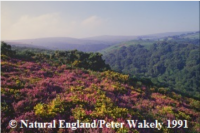

<Item title:"National Parks (England)" type:Feature Layer Collection owner:Opendata_NE>
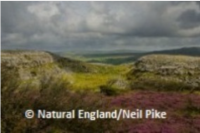

In [7]:
# display the ietems
data = [LE_item, NPE_item]
for item in data:
    display(item)

In [12]:
# download the data
NPE = extract_data([NPE_item], data_format = 'Shapefile')
NPE.download('NPE')
##LE = extract_data([LE_item], data_format = 'Shapefile')
##LE.download('LE')

'NPE\\Extracted_data_SVXHF9.zip'

In [ ]:
# add the data to the geodatabase
fcs = arcpy.ListFeatureClasses()
for fc in fcs:
    desc = arcpy.da.Describe(fc)
    outfc = os.path.join(outgdb, desc["baseName"])
    arcpy.CopyFeatures_management(fc, outfc)

## Data pre-processing¶

1. Re-set the WS env & Clip the data to NPE boundaries
2. Call geopandas to create a df and use Pandas for data processing.
3. Create a new column [AREA_CLIP] using the clipped geometry and add the calculated area (as data has been clipped). This new column shows the area (sqkm) just inside the National Parks boundary.
4. Sjoin the NPE data to the ES and CS data so the data can be analysed collectively and individually for all NP's

In [6]:
# Clip the data to National Park England
arcpy.Clip_analysis("Living_England_Habitat_Map_Phase_4___Natural_England", "NPE")

In [15]:
# create a geopandas data frame for NPE 
NPE = gpd.read_file("NPE.shp")

In [11]:
# Create a geopandas data frame for NPE
NPE_LE = gpd.read_file("Living_England_Habitat_Map_NPE.shp")

In [12]:
# Take a look at the data make sure it is ok :)
NPE_LE.head()

,ID,A_pred,A_prob,B_pred,B_prob,SrcCode,ImagesSpr,ImagesAut,SHAPE_Leng,SHAPE_Area,geometry
0,13001942,Dwarf Shrub Heath,89.2,"Acid, Calcareous, Neutral Grassland",5.8,1,01/04/2021 - 30/04/2021,01/09/2020 - 30/09/2020,800.0,16800.0,"POLYGON ((256920.000 66320.000, 256920.000 662..."
1,13001943,Bog,45.0,"Acid, Calcareous, Neutral Grassland",40.2,1,01/04/2021 - 30/04/2021,01/09/2020 - 30/09/2020,1480.0,33200.0,"POLYGON ((258860.000 64250.000, 258860.000 642..."
2,13001944,"Acid, Calcareous, Neutral Grassland",45.6,Dwarf Shrub Heath,33.6,1,01/04/2021 - 30/04/2021,01/09/2020 - 30/09/2020,1720.0,19900.0,"POLYGON ((258860.000 64260.000, 258860.000 642..."
3,13001947,Bog,94.2,"Acid, Calcareous, Neutral Grassland",4.4,1,01/04/2021 - 30/04/2021,01/09/2020 - 30/09/2020,840.0,22500.0,"POLYGON ((264330.000 68740.000, 264320.000 687..."
4,13001948,Bog,91.8,"Acid, Calcareous, Neutral Grassland",6.6,1,01/04/2021 - 30/04/2021,01/09/2020 - 30/09/2020,1120.0,21400.0,"POLYGON ((264140.000 68690.000, 264140.000 686..."


In [13]:
# create the area column
NPE_LE['AREA_CLIP'] = NPE_LE['geometry'].area/10**6
NPE_LE.head()

,ID,A_pred,A_prob,B_pred,B_prob,SrcCode,ImagesSpr,ImagesAut,SHAPE_Leng,SHAPE_Area,geometry,AREA_CLIP
0,13001942,Dwarf Shrub Heath,89.2,"Acid, Calcareous, Neutral Grassland",5.8,1,01/04/2021 - 30/04/2021,01/09/2020 - 30/09/2020,800.0,16800.0,"POLYGON ((256920.000 66320.000, 256920.000 662...",0.0168
1,13001943,Bog,45.0,"Acid, Calcareous, Neutral Grassland",40.2,1,01/04/2021 - 30/04/2021,01/09/2020 - 30/09/2020,1480.0,33200.0,"POLYGON ((258860.000 64250.000, 258860.000 642...",0.0332
2,13001944,"Acid, Calcareous, Neutral Grassland",45.6,Dwarf Shrub Heath,33.6,1,01/04/2021 - 30/04/2021,01/09/2020 - 30/09/2020,1720.0,19900.0,"POLYGON ((258860.000 64260.000, 258860.000 642...",0.0199
3,13001947,Bog,94.2,"Acid, Calcareous, Neutral Grassland",4.4,1,01/04/2021 - 30/04/2021,01/09/2020 - 30/09/2020,840.0,22500.0,"POLYGON ((264330.000 68740.000, 264320.000 687...",0.0225
4,13001948,Bog,91.8,"Acid, Calcareous, Neutral Grassland",6.6,1,01/04/2021 - 30/04/2021,01/09/2020 - 30/09/2020,1120.0,21400.0,"POLYGON ((264140.000 68690.000, 264140.000 686...",0.0214


In [16]:
# create a spatial join and append the NPE to the left of the gpd for NPE_LE
NPE_LE = gpd.sjoin(NPE, NPE_LE, how="inner", op="intersects")
# take a look at the first 2 rows of the df to check :)
NPE_LE.head(2)

,CODE,NAME,MEASURE,DESIG_DATE,HOTLINK,STATUS,Shape__Are,Shape__Len,geometry,index_right,ID,A_pred,A_prob,B_pred,B_prob,SrcCode,ImagesSpr,ImagesAut,SHAPE_Leng,SHAPE_Area,AREA_CLIP
0,10,SOUTH DOWNS,1653.0,2010-03-31,http://southdowns.gov.uk/,Designated,1.652679e+09,602554.506861,"POLYGON ((484696.203 108041.303, 484694.801 10...",144374,10597045,Dwarf Shrub Heath,31.2,"Broadleaved, Mixed and Yew Woodland",26.2,1,01/04/2021 - 30/04/2021,01/09/2020 - 30/09/2020,2177.464054,15924.82706,0.015925
0,10,SOUTH DOWNS,1653.0,2010-03-31,http://southdowns.gov.uk/,Designated,1.652679e+09,602554.506861,"POLYGON ((484696.203 108041.303, 484694.801 10...",145076,10621289,Arable and Horticultural,0.0,None,0.0,22,01/04/2021 - 30/04/2021,01/09/2020 - 30/09/2020,460.000000,11100.00000,0.011100


## Data Analysis NPE

Plot the data to check the cut data 

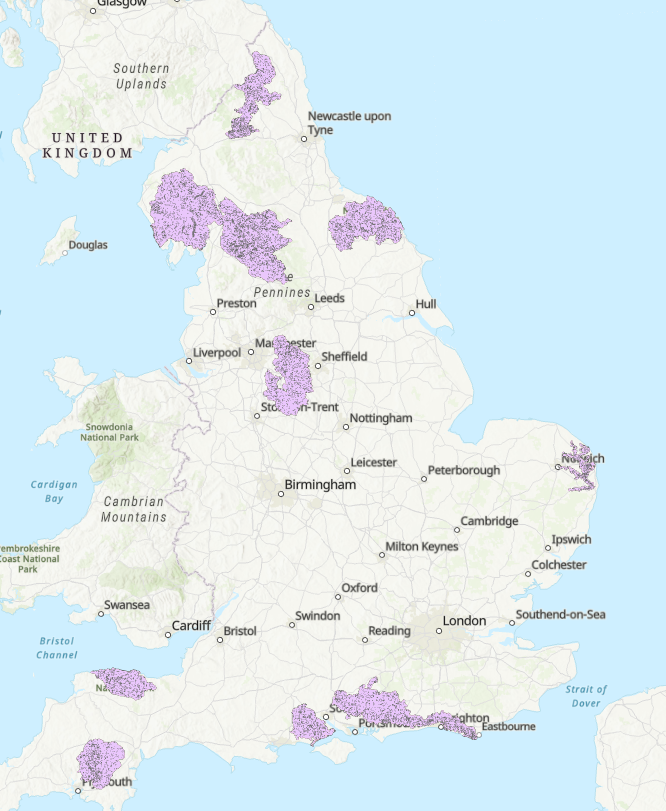

In [23]:
### 

table = pd.pivot_table(NPE_LE, values = 'AREA_CLIP', index = 'NAME', columns = 'A_pred', aggfunc=np.sum)
table

A_pred,"Acid, Calcareous, Neutral Grassland",Arable and Horticultural,Bare Ground,Bare Sand,Bog,Bracken,"Broadleaved, Mixed and Yew Woodland",Built-up Areas and Gardens,Coastal Saltmarsh,Coastal Sand Dunes,Coniferous Woodland,Dwarf Shrub Heath,"Fen, Marsh and Swamp",Improved Grassland,Scrub,Unclassified,Water
NAME,,,,,,,,,,,,,,,,,
DARTMOOR,360.323257,16.517767,0.135744,NaN,164.325200,2.824345,88.947079,5.879331,NaN,NaN,32.630482,164.153920,59.501669,56.700165,NaN,1.898200,1.910303
EXMOOR,321.484319,18.347423,0.066936,0.196975,33.327600,4.773703,77.411012,2.671398,0.548969,0.143715,27.923897,125.003614,26.968463,46.225485,NaN,1.532500,1.955786
LAKE DISTRICT,527.302621,22.300515,6.279754,1.143910,27.077687,50.165300,273.454985,9.763699,3.094136,5.227658,84.473115,113.739029,824.325452,325.409153,7.302628,0.400980,63.301814
NEW FOREST,108.042040,19.564446,NaN,0.528884,NaN,18.049182,93.292663,6.013578,1.013889,6.174190,73.519449,54.859822,99.351447,62.332096,7.279128,1.998465,1.465358
NORTH YORK MOORS,260.902230,125.937271,0.347471,NaN,10.567136,0.374042,152.142848,7.146889,NaN,NaN,179.711883,391.179556,121.763205,182.365521,0.087800,2.188891,1.391260
NORTHUMBERLAND,186.887106,5.271335,0.225000,NaN,186.074616,204.488944,44.526862,0.696086,NaN,NaN,128.316403,144.640100,22.302273,108.866018,NaN,16.459762,2.094393
PEAK DISTRICT,671.337045,12.474539,1.699613,NaN,157.916587,51.621340,111.671172,9.304145,NaN,NaN,32.792207,244.426922,45.793487,85.991736,NaN,1.633144,11.169875
SOUTH DOWNS,443.874794,447.042222,0.046600,5.444288,NaN,9.339225,231.421207,20.352998,0.061253,14.947990,53.871928,55.159923,4.217005,285.255074,72.126808,3.445345,2.174426
THE BROADS,32.604968,45.855191,0.060042,0.282089,0.014461,NaN,40.839789,2.151914,0.076077,1.814894,0.385871,0.847914,39.316565,115.748460,0.133578,0.164036,9.991240
